Time taken for completion == 4.5 hours

- The file requirements.txt contains the packages required to run the notebook
- Quantized model is stored in the path "MISHA_RANA/tflitetfliteModels/tflite_quantized_model.tflite"
- The folder dataset should contain the provided dataset having 'train' and 'test' folders. 
- Auxiliary files : lrfinder.py and find_LR_auxilliary.ipynb 

# Data Preparation

- For data preparation the given training data was split into training and validation sets in 80:20 rario respectively. 

- The test data has been left untouched for evaluation. 

In [8]:
import os
from shutil import copyfile, copytree
import numpy as np
import cv2
from PIL import Image
import time
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings

In [9]:
!mkdir data
!mkdir data/train
!mkdir data/valid


In [10]:
DATA_DIR = "dataset/"   # original data path 
NEW_DATA_DIR = "data/"  # path to the train, val and test data

In [11]:
import random
from shutil import copyfile
for x in os.listdir(os.path.join(DATA_DIR, 'train/')):
    if x == ".DS_Store" or x == ".ipynb_checkpoints":
        pass
    else:
        images = os.listdir(os.path.join(DATA_DIR, 'train/')+x)
        random.shuffle(images)
        break_idx = int(0.2*len(images))
        print(break_idx,len(images),x)
        if(not os.path.isdir(os.path.join(NEW_DATA_DIR, 'valid/')+x)):
            os.mkdir(os.path.join(NEW_DATA_DIR, 'valid/')+x)
        if(not os.path.isdir(os.path.join(NEW_DATA_DIR, 'train/')+x)):
            os.mkdir(os.path.join(NEW_DATA_DIR, 'train/')+x)
                    
        for idx in range(len(images)):
            if(idx>=break_idx):
                copyfile(os.path.join(DATA_DIR, 'train/')+x+"/"+images[idx],os.path.join(NEW_DATA_DIR, 'train/')+x+"/"+images[idx])
            else:
                copyfile(os.path.join(DATA_DIR, 'train/')+x+"/"+images[idx],os.path.join(NEW_DATA_DIR, 'valid/')+x+"/"+images[idx])

41 206 blackspot
40 201 canker
77 388 fresh
73 369 grenning


In [12]:
# Copy test data 
src = os.path.join(DATA_DIR,'test/')
dest = os.path.join(NEW_DATA_DIR,'test/')
destination = copytree(src, dest) 

# Data visualisation


- The count of each class has been visualised using a bar graph. 
- The resultant graph shows that there are more samples belonging to 'fresh' and 'grening' classes than 'blackspot' and 'canker' classes. 

In [13]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import glob
import matplotlib.pyplot as plt

In [14]:
APP_FOLDER=os.path.join(DATA_DIR,'train/') #folder with entire data


totalFiles = 0 # total files
df = []
for dirpath, dirnames, filenames in os.walk(APP_FOLDER):
    counter = len(filenames)
    totalFiles += counter
    className = dirpath.split('/')[-1]
    if className != "":
        df.append([className, counter])

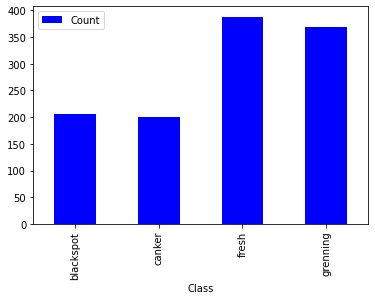

<Figure size 432x144 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [20]:
df = pd.DataFrame(df,columns=['Class','Count'])
df.plot(x ='Class', y='Count', kind = 'bar', color = "blue")
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(2)
plt.show()
plt.savefig("data_distribution.png")


# Data Loading

- The data is loaded into train, vaild and test batches. 
- THe train and valid batches will be used for training and test batch will be used during model evaluation. 

In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf. __version__) 

2.9.1


In [17]:
train_path = os.path.join(NEW_DATA_DIR,"train/")
valid_path = os.path.join(NEW_DATA_DIR,"valid/")
test_path = os.path.join(NEW_DATA_DIR,"test/")


In [ ]:
train_batches = ImageDataGenerator(rotation_range=20 , horizontal_flip = True, preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=train_path,shuffle=True, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(rotation_range=20 , horizontal_flip = True,preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=valid_path, shuffle=True, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)
    

In [18]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=train_path,shuffle=True, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=valid_path, shuffle=True, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)
    

Found 933 images belonging to 4 classes.
Found 231 images belonging to 4 classes.
Found 626 images belonging to 4 classes.


In [19]:
print(train_batches.class_indices)  

{'blackspot': 0, 'canker': 1, 'fresh': 2, 'grenning': 3}


# Training description : 

- ##  Model Architecture


- **Base Model**: 
    - The network is based on EfficientNet-B0, which is the baseline network. EfficientNet is chosen as it is smaller in size, faster and has achieved state of the art accuracy on the ImageNet dataset. Transfer learning approach has been used to train the architecture. 

    - A pretrained EfficientNet-B0 trained on imagenet dataset is used as the base model. 
   


- **Classification Model**: 
    - To create our own classification stack on top of the EfficientNet-B0 convolutional base model, GlobalAveragePooling2D layer is used to convert the 4D tensor (batch_size, rows, cols, channels), to 2D tensor with shape (batch_size, channels). Compared to the Flatten layer, GlobalAveragePooling2D reduces the number of parameters. This is followed by a BatchNormalization layer -> Dropout -> Dense (512) ->LeakyReLU Activation function -> Dense(4).
    -  LeakyReLU has been used because it has the advantage that instead of sending negative values to zero, a very small slope parameter is used which incorporates some information from negative values.
    -  Softmax activation has been applied to the last Dense layer with 4 output neurons.  
    - We also apply augmentations:  RandomRotation, CenterCrop, RandomTranslation, RandomFlip and Randomcontrast on the input images before feeding them into the model. 

In [21]:
# Imports
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import the Desired Version of EfficientNet
from tensorflow.keras.applications import EfficientNetB0


- # Hyperparameters

- LEARNING RATE : Lerning Rate is set to 0.001. This was chosen based on the LRFinder algorithm (code attached) which suggested an optimal learning rate (steep curve) between 1e-3 and less than 1e-2. Hence, 0.001 is a good value for learning rate
                ![An image](LRFinder.png)
- EPOCHS : The number of epochs was chosen as 10 but **early stopping** callback was applied to prevent overfitting.  The **validation loss** is monitored for early stopping with a patience=3 .The model trains for 6 epochs before callback halts training.

- LOSS : **Categorical cross-entropy** has been chossen as the loss function because the problem is multi-class classification. 

- OPTIMISER : Adam optimiser has been chosen with a leraning rate of 0.001 because of its speed of computation and it requries fewer parameters for tuning. 

In [22]:
NUM_CLASSES = 4
EPOCHS = 10 
LEARNING_RATE = 0.001
class_names = ['blackspot', 'canker', 'fresh', 'grenning']

In [23]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
        preprocessing.CenterCrop(224,224)
    ],
    name="img_augmentation",
)


In [24]:
def build_model(NUM_CLASSES):
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)
    #Using the imported version of EfficientNet
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    # Freeze the pretrained weights
    model.trainable = False


    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3, name="top_dropout_1")(x)
    x = layers.Dense(512, name = "top_dense")(x)
    x = layers.Dropout(0.2, name="top_dropout_2")(x)
    x = layers.LeakyReLU( name="top_actviation")(x)
 
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model



In [25]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    

In [26]:
model = build_model(NUM_CLASSES)

In [27]:
!mkdir checkpoints/
checkpoint_path = 'checkpoints/'+"cp.ckpt"
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
            

In [28]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [29]:
history = model.fit(train_batches, epochs=EPOCHS, validation_data=valid_batches, verbose=1,callbacks=[callback,early_stop])
    

Epoch 1/10


94/94 [==============================] - ETA: 0s - loss: 0.3589 - accuracy: 0.9110
Epoch 1: saving model to checkpoints/cp.ckpt
94/94 [==============================] - 41s 259ms/step - loss: 0.3589 - accuracy: 0.9110 - val_loss: 0.2545 - val_accuracy: 0.8918
Epoch 2/10
94/94 [==============================] - ETA: 0s - loss: 0.1873 - accuracy: 0.9496
Epoch 2: saving model to checkpoints/cp.ckpt
94/94 [==============================] - 24s 258ms/step - loss: 0.1873 - accuracy: 0.9496 - val_loss: 0.1588 - val_accuracy: 0.9481
Epoch 3/10
94/94 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.9539
Epoch 3: saving model to checkpoints/cp.ckpt
94/94 [==============================] - 22s 233ms/step - loss: 0.2259 - accuracy: 0.9539 - val_loss: 0.0946 - val_accuracy: 0.9827
Epoch 4/10
94/94 [==============================] - ETA: 0s - loss: 0.2999 - accuracy: 0.9507
Epoch 4: saving model to checkpoints/cp.ckpt
94/94 [==============================] - 23s 246ms/step - l

In [30]:
model.save("saved_model.h5")

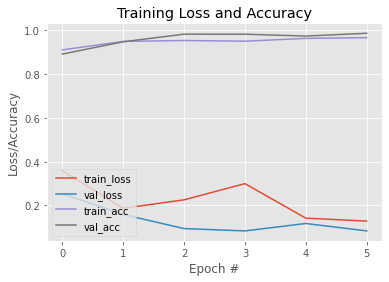

In [31]:
N = 6
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("lossVSaccuracy.png")

# Model Evaluation :

- The test accuracy of the model is 98.7% on the provided test dataset.
-  Classification Report:
    class_name |precision | recall |f1-score | support 
    -----------|----------|--------|---------|------------
    blackspot  | 0.96     | 0.99   |  0.97   |    138
      canker   |    0.99  |  0.96  |   0.97  |    148
      fresh    |   1.00   |   1.00 |  1.00   |    164
    grenning   |   1.00   |  1.00  |   1.00  |    176
    accuracy   |          |        |    0.99 |    626
   macro avg   |    0.99  |   0.99 |    0.99 |    626
   weighted avg|    0.99  |   0.99 |    0.99 |     626
   
- Confusion Matrix:    
            
    ![An image](confusion_matrix.png)
   
   

In [33]:
def test_model(model,test_batches):
    #Testing the Model
    test_labels = test_batches.classes
    
    predictions = model.predict(test_batches,steps=len(test_batches),verbose=0)
    
    acc = 0
    pred_arr = []
    for i in range(len(test_labels)):
        actual_class = test_labels[i]
        if predictions[i][actual_class] > 0.5 : 
            acc += 1


        
        values = predictions[i]
        index_max = np.argmax(values)
        
        pred_arr.append(index_max)
    print("Accuarcy:",(acc/len(test_labels))*100,"%")
    return test_labels, np.asarray(pred_arr)


#Testing the Model
test_labels, pred_labels = test_model(model,test_batches)

Accuarcy: 98.7220447284345 %


In [34]:
print('Classification Report:\n', classification_report(test_labels, pred_labels, target_names = class_names))

Classification Report:
               precision    recall  f1-score   support

   blackspot       0.96      0.99      0.97       138
      canker       0.99      0.96      0.97       148
       fresh       1.00      1.00      1.00       164
    grenning       1.00      1.00      1.00       176

    accuracy                           0.99       626
   macro avg       0.99      0.99      0.99       626
weighted avg       0.99      0.99      0.99       626



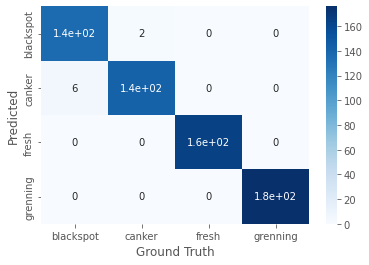

In [35]:
cnf = confusion_matrix(test_labels, pred_labels)
cnf_df = pd.DataFrame(cnf,columns = class_names,index=class_names)
ax = sns.heatmap(cnf_df,annot=True, cmap='Blues')
ax.set(xlabel='Ground Truth', ylabel='Predicted')
plt.savefig("confusion_matrix.png")

In [36]:
!mkdir saved_model
tf.saved_model.save(model, "saved_model/")
!mkdir tfliteModels

# Real-world application : 

- ## Model Quantization

Post-training quantization is used to reduce the model size from  17.8 Mb to 4.9 Mb. Accuracy of tflite model 98.4% and Accuracy of quantized model 98.7%.



In [ ]:
# Quantized model paths 
TF_LITE_PATH = "tfliteModels/tflite_model.tflite"
TF_LITE_QUANT_PATH = "tfliteModels/tflite_quantized_model.tflite"

In [ ]:
# converting model to tflite 
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/")
tf_lite_model = converter.convert()

#post-training quantisation
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_quant_model = converter.convert()
with open(TF_LITE_PATH,"wb") as f:
    f.write(tf_lite_model)
with open(TF_LITE_QUANT_PATH,"wb") as f:
    f.write(tf_lite_quant_model)

- ## Evaluating quantized models accuracy 

In [39]:
def get_predictions(TF_LITE_PATH,class_names):
    model_path = TF_LITE_PATH
    interpreter = tf.lite.Interpreter(model_path=model_path)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    ### Cerate interpreter for the specified model
    
    input_shape = input_details[0]['shape']

    size = input_shape[1:3]
    pred_arr = []
    
    for i in range(0, len(class_names)):

        for images in os.listdir(test_path+class_names[i]):

            ### Fetch image & preprocess it to match the input requirements of the model
            
            file_path = os.path.join(test_path,class_names[i], images)

            img = Image.open(file_path) #.convert('RGB')
            img = img.resize(size)
            img = np.array(img)
            img = img.astype(np.float32)
            
            ### Now allocate tensors so that we can use the set_tensor() method to feed the processed_image
            processed_image = np.expand_dims(img, axis=0)
            interpreter.allocate_tensors()
            interpreter.set_tensor(input_details[0]['index'], processed_image)
            interpreter.invoke()
            predictions = interpreter.get_tensor(output_details[0]['index'])[0]
            pred_arr.append(predictions)
    
    return pred_arr


    

In [40]:
def eval(TF_LITE_PATH,class_names):
    pred_arr = get_predictions(TF_LITE_PATH,class_names)
    pred_labels = []
    for i in pred_arr:
      #print(i)
      pred_labels.append(i.argmax(axis=0))
    test_labels = test_batches.classes
    pred_labels_arr = np.array(pred_labels)
    acc = accuracy_score(np.array(test_labels), np.array(pred_labels_arr))
    return acc


In [41]:
acc = eval(TF_LITE_PATH,class_names)
acc_quant = eval(TF_LITE_QUANT_PATH,class_names)


In [42]:
print(f"Accuracy of tflite model {acc*100} and Accuracy of quantised model {acc_quant*100}" )

Accuracy of tflite model 98.40255591054313 and Accuracy of quantised model 98.7220447284345


In [43]:
print("Float model in Mb:", os.path.getsize(TF_LITE_PATH) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(TF_LITE_QUANT_PATH) / float(2**20))

Float model in Mb: 17.80327606201172
Quantized model in Mb: 4.966361999511719
